In [21]:
import warnings
warnings.filterwarnings("ignore")

import os
import time
import shutil
import numpy as np
import pandas as pd
from glob import glob
from patsy import dmatrices
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import ast
from datetime import datetime

In [22]:
# Define Base Directory
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Navigate to project root

# Function to join paths
def jo(directory, filename):
    """Joins a directory and filename."""
    return os.path.join(directory, filename)



# Function to load raw datasets
def load_data(base_dir):
    """Loads raw datasets from the data directory."""
    data_dir = jo(base_dir, "data")
    
    file_names = {
        "df_C": "listings_Q2_C.csv",
        "df_S": "listings_Q2_S.csv",
        "df_C_Q3": "listings_Q3_C.csv",
    }
    
    dataframes = {}

    for key, file in file_names.items():
        file_path = jo(data_dir, file)
        if os.path.exists(file_path):
            dataframes[key] = pd.read_csv(file_path)
            print(f"✅ Loaded {key} - Shape: {dataframes[key].shape}")
        else:
            print(f"⚠ Error: {file_path} not found. Skipping {key}.")
    
    return dataframes

# Function to delete  processed  datasets
def delete_processed_data(base_dir):
    """Deletes all files inside the processed_data directory before saving new ones."""
    processed_data_dir = os.path.join(base_dir, "processed_data")

    if os.path.exists(processed_data_dir):
        for file in os.listdir(processed_data_dir):
            file_path = os.path.join(processed_data_dir, file)
            try:
                os.remove(file_path)  # Remove file
            except Exception as e:
                print(f"⚠ Error deleting {file_path}: {e}")
        print(f"🗑️ Deleted all files inside {processed_data_dir}")
    else:
        print(f"⚠ Warning: {processed_data_dir} does not exist.")
        
# Function to load cleaned datasets
def load_cleaned_data(base_dir):
    """Loads cleaned datasets from the processed data directory."""
    processed_data_dir = jo(base_dir, "processed_data")

    file_names = {
        "df_C_cleaned": "df_C_CLEANED.csv",
        "df_S_cleaned": "df_S_CLEANED.csv",
        "df_C_Q3_cleaned": "df_C_Q3_CLEANED.csv",
    }

    dataframes = {}

    for key, file in file_names.items():
        file_path = jo(processed_data_dir, file)
        if os.path.exists(file_path):
            dataframes[key] = pd.read_csv(file_path)
            print(f"✅ Loaded {key} - Shape: {dataframes[key].shape}")
        else:
            print(f"⚠ Error: {file_path} not found. Skipping {key}.")

    return dataframes


# Function to save cleaned data
def save_cleaned_data(df, base_dir, filename_prefix="listings_CLEANED"):
    """Saves a cleaned dataframe with a timestamped filename."""
    processed_data_dir = jo(base_dir, "processed_data")
    os.makedirs(processed_data_dir, exist_ok=True)

    # timestamp = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M")
    # filename = f"{filename_prefix}_{timestamp}.csv"
    filename = f"{filename_prefix}.csv"

    file_path = jo(processed_data_dir, filename)

    df.to_csv(file_path, index=False)
    print(f"✅ Cleaned data saved at: {file_path}")
    return file_path

In [23]:
# Load all cleaned datasets
datasets = load_data(base_dir)

✅ Loaded df_C - Shape: (20909, 75)
✅ Loaded df_S - Shape: (5400, 75)
✅ Loaded df_C_Q3 - Shape: (21528, 75)


## Data Processing Functions


### Data Cleaning
- `drop_unnecessary_columns(df)` Removes irrelevant columns from the dataset
- `clean_missing_values(df)` Drops columns with too many missing values
- `fill_numeric_missing_values(df)` Fills missing numeric values with mean/median
- `clean_price(df)` Converts price column to numeric and removes outliers
- `clean_host_acceptance_rate(df)` Converts host acceptance rate to numeric

### Feature Engineering
- `process_boolean_columns(df)` Converts boolean values and fills missing data
- `process_amenities(df, top_n=10)` Extracts and encodes top N amenities
- `process_bathrooms(df)` Extracts numeric bathroom count and adds indicators
- `extract_bathrooms(text)` Parses text descriptions to get numeric bathroom count
- `categorize_property_type(df)` Categorizes properties into Apartment, House, or Other
- `calculate_distance_to_center(df)` Computes distance from the city center
- `process_neighbourhood(df, top_n=5)` Keeps top N neighborhoods and one-hot encodes them

### Filtering & Preprocessing
- `filter_data(df)` Filters out listings with excessive accommodations

## Dropped Columns and Reasons

### Metadata and Identifiers
- `host_location` Redundant, as we already have latitude/longitude
- `id` Unique identifier, not useful for prediction
- `scrape_id` Internal identifier, not relevant for analysis
- `last_scraped` Date of last data collection, not useful for modeling
- `source` Source of the data, does not impact price prediction
- `host_id` Unique identifier for the host, not useful for modeling
- `host_url` URL of the host’s profile, irrelevant for analysis
- `listing_url` URL of the listing, not needed for modeling

### Textual Descriptions
- `description` Free-text field, difficult to use directly
- `name` Listing title, not structured data for price prediction
- `neighborhood_overview` Free-text overview of the neighborhood, not structured
- `host_about` Free-text host description, not useful for numerical analysis

### Images and Media
- `picture_url` Link to images, not useful for numerical modeling
- `host_thumbnail_url` Profile picture thumbnail, not relevant
- `host_picture_url` Profile picture, irrelevant for price prediction

### Host Information
- `host_since` Host registration date, may not impact price significantly
- `host_total_listings_count` Duplicates `calculated_host_listings_count`
- `host_listings_count` Redundant and not critical for price estimation
- `host_name` Host's name, not relevant for numerical analysis
- `host_verifications` List of verification methods, not structured data

### Licensing and Regulations
- `license` Regulatory information, varies by region, not relevant
- `calendar_updated` Not structured enough for direct use
- `calendar_last_scraped` Similar to `last_scraped`, not useful

### Neighborhood Data
- `neighbourhood_group_cleansed` Not available for all cities, redundant with other features

### Derived Listing Counts
- `calculated_host_listings_count_entire_homes` Redundant with other listing count data
- `calculated_host_listings_count_private_rooms` Similar to `host_listings_count`
- `calculated_host_listings_count_shared_rooms` Redundant with listing count columns


In [24]:
# # Custom Imports
# from readFile import load_data, save_cleaned_data, jo
# from FeatureEngineering import get_predictors

# ----------------------------------------

CITY_CENTER_LAT = 55.6761
CITY_CENTER_LON = 12.5683
DROP_THRESHOLD = 4000
MAX_ACCOMMODATES = 8
MAX_PRICE = 100000

COLUMNS_TO_DROP = [
    "host_location", "id", "description", "name", "listing_url", "neighborhood_overview",
    "host_since", "scrape_id", "last_scraped", "source", "picture_url", 
    "host_total_listings_count", "host_listings_count", "host_id", "host_url",
    "host_name", "host_thumbnail_url", "host_picture_url", "host_about", 
    "host_verifications", "calendar_last_scraped", "license", 
    "neighbourhood_group_cleansed", "calculated_host_listings_count_entire_homes", 
    "calculated_host_listings_count_private_rooms", "calculated_host_listings_count_shared_rooms",
    "calendar_updated"
]

NUMERIC_COLS_TO_FILL = [
    "first_review", "last_review", "review_scores_rating",
    "review_scores_accuracy", "review_scores_cleanliness",
    "review_scores_checkin", "review_scores_communication",
    "review_scores_location", "review_scores_value", "reviews_per_month"
]

BOOLEAN_COLS = [
    "host_is_superhost", "host_identity_verified", "instant_bookable",
    "host_has_profile_pic", "host_acceptance_rate", "has_availability"
]

PROPERTY_CATEGORIES = {
    "apartment": [
        "Entire rental unit", "Entire condo", "Entire serviced apartment", 
        "Entire loft", "Room in aparthotel", "Private room in rental unit", 
        "Private room in condo", "Private room in serviced apartment"
    ],
    "house": [
        "Entire home", "Entire townhouse", "Entire villa", "Entire guesthouse", 
        "Entire bungalow", "Private room in home", "Private room in townhouse", 
        "Private room in villa", "Private room in guest suite", "Tiny home", 
        "Houseboat", "Boat", "Cabin", "Cottage", "Farm stay", "Entire cabin",
        "Entire vacation home", "Private room in vacation home"
    ]
}


# ----------------------------------------
# 🔹 Utility Functions
# ----------------------------------------

def log_step(message):
    """Print a formatted log message for process steps."""
    print(f"\n📊 {message}")

def drop_unnecessary_columns(df):
    """Drop irrelevant columns for price prediction."""
    return df.drop(columns=[col for col in COLUMNS_TO_DROP if col in df.columns], errors="ignore")

def clean_missing_values(df):
    """Remove columns with too many missing values, except essential ones."""
    columns_to_keep = {"price", "reviews_per_month"}  # Essential columns to keep
    filtered_cols = [col for col in df.columns if col in columns_to_keep or df[col].isnull().sum() <= DROP_THRESHOLD]
    df_filtered = df[filtered_cols]
    
    # Drop rows where price is NaN (since price is the target variable)
    return df_filtered.dropna(subset=["price"])

def fill_numeric_missing_values(df):
    """Fill missing values in numeric columns with mean/median."""
    for col in NUMERIC_COLS_TO_FILL:
        if col in df.columns:
            if pd.api.types.is_numeric_dtype(df[col]):
                df[col].fillna(df[col].mean(), inplace=True)
            elif col in ["first_review", "last_review"]:
                df[col] = pd.to_datetime(df[col], errors="coerce")
                if df[col].notna().any():
                    df[col].fillna(df[col].median(), inplace=True)
    return df

def process_boolean_columns(df):
    """Convert 't'/'f' to 1/0 and fill missing values with mode."""
    for column in BOOLEAN_COLS:
        if column in df.columns:
            df[column].fillna(df[column].mode()[0], inplace=True)
            df[column] = df[column].replace({"t": 1, "f": 0})
    return df


def process_amenities(df, top_n=10):
    """Extract top amenities and create binary features."""
    import ast
    if "amenities" not in df.columns:
        return df

    # Ensure amenities are lists (handle string representations)
    df["amenities"] = df["amenities"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # Flatten the list of amenities
    all_amenities = [amenity for sublist in df["amenities"].dropna() for amenity in sublist]

    # Get the top N most common amenities
    top_amenities = pd.Series(all_amenities).value_counts().head(top_n).index

    # Create binary features for top amenities
    for amenity in top_amenities:
        column_name = f"amenity_{amenity.replace(' ', '_').lower()}"
        df[column_name] = df["amenities"].apply(
            lambda x: int(amenity in x) if isinstance(x, list) else 0
        )

    # Drop the original amenities column
    df.drop(columns=["amenities"], inplace=True)

    return df

def process_bathrooms(df):
    """Extract numeric bathroom values and create shared/private indicators."""
    if "bathrooms_text" not in df.columns:
        return df

    # Extract numeric bathroom count
    df["bathrooms"] = df["bathrooms_text"].apply(extract_bathrooms)

    # Create 'is_shared' and 'is_private' indicators
    df["is_shared"] = df["bathrooms_text"].str.contains("shared", case=False, na=False).astype(int)
    df["is_private"] = df["bathrooms_text"].str.contains("private", case=False, na=False).astype(int)

    # Fill missing bathroom values with mean
    df["bathrooms"].fillna(df["bathrooms"].mean(), inplace=True)

    # Drop the original bathrooms_text column
    df.drop(columns=["bathrooms_text"], inplace=True)

    return df

def extract_bathrooms(text):
    """Extract numeric bathroom count from text description."""
    if pd.isna(text):
        return None
    text = text.lower()
    
    if "half" in text:
        return 0.5

def clean_price(df):
    """Convert price column to numeric and remove outliers."""
    df["price"] = df["price"].astype(str).str.replace(r"[$,]", "", regex=True).astype(float)
    return df[df.price < MAX_PRICE]

def clean_host_acceptance_rate(df):
    """Convert host_acceptance_rate to numeric by removing percentage symbol."""
    if "host_acceptance_rate" in df.columns:
        df["host_acceptance_rate"] = df["host_acceptance_rate"].astype(str).str.replace("%", "", regex=True).astype(float)
    return df

def categorize_property_type(df):
    """Categorize property types into apartment, house, or other."""
    def categorize(property_type):
        if property_type in PROPERTY_CATEGORIES["apartment"]:
            return "Apartment"
        elif property_type in PROPERTY_CATEGORIES["house"]:
            return "House"
        return "Other"

    df["property_type"] = df["property_type"].apply(categorize)
    return df

def calculate_distance_to_center(df):
    """Calculate distance from listing to city center using Haversine formula."""
    from math import radians, sin, cos, sqrt, atan2

    def haversine(lat1, lon1, lat2, lon2):
        R = 6371.0
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlat, dlon = lat2 - lat1, lon2 - lon1
        a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        return R * c

    df["dist_to_center"] = df.apply(lambda row: haversine(CITY_CENTER_LAT, CITY_CENTER_LON, row["latitude"], row["longitude"]), axis=1)
    df.drop(columns=["latitude", "longitude"], inplace=True)
    return df

def process_neighbourhood(df, top_n=5):
    """Keep only top N neighborhoods and one-hot encode them."""
    if "neighbourhood_cleansed" not in df.columns:
        return df

    top_neighbourhoods = df["neighbourhood_cleansed"].value_counts().nlargest(top_n).index
    df["neighbourhood_cleansed"] = df["neighbourhood_cleansed"].apply(lambda x: x if x in top_neighbourhoods else "Other")
    df = pd.get_dummies(df, columns=["neighbourhood_cleansed"], drop_first=True)
    return df

def filter_data(df):
    """Apply filters to remove outliers and irrelevant data."""
    # Filter by number of accommodates
    df = df[df.accommodates < MAX_ACCOMMODATES]
    return df

# ----------------------------------------
# 🔹 Main Processing Pipeline
# ----------------------------------------

### `main()`
This function orchestrates the data processing pipeline, handling data loading, cleaning, transformation, and saving.

In [25]:
def main():
    """Main execution function for data preparation."""
    base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
    
    log_step("Loading datasets")
    datasets = load_data(base_dir)
    
    #  Delete all previously processed files before starting new processing
    delete_processed_data(base_dir)

    cleaned_datasets = {}
    # Check available columns before transformations
    for key, df in datasets.items():
        if df is None:
            continue
        print(f"\n🔍 Dataset: {key} - Columns: {df.columns.tolist()}")

    cleaned_datasets = {}

    for key, df in datasets.items():
        if df is None:
            continue

        log_step(f"Processing {key}")

        df = (df
              .pipe(drop_unnecessary_columns)
              .pipe(clean_missing_values)  # This was causing KeyError
              .pipe(clean_price)
              .pipe(clean_host_acceptance_rate)
              .pipe(fill_numeric_missing_values)
              .pipe(process_boolean_columns)
              .pipe(process_amenities)
              .pipe(process_bathrooms)
              .pipe(categorize_property_type)
              .pipe(calculate_distance_to_center)
              .pipe(process_neighbourhood)
              .pipe(filter_data)
        )

        cleaned_datasets[key] = df

        print(f"✅ Processed {key}: {df.shape[0]} rows, {df.shape[1]} columns")
         # 🔹 Save cleaned dataset using the provided function
        save_cleaned_data(df, base_dir, filename_prefix=f"{key}_CLEANED")

    return cleaned_datasets


In [26]:
if __name__ == "__main__":
    cleaned_datasets = main()


📊 Loading datasets
✅ Loaded df_C - Shape: (20909, 75)
✅ Loaded df_S - Shape: (5400, 75)
✅ Loaded df_C_Q3 - Shape: (21528, 75)
🗑️ Deleted all files inside c:\Users\sarkhanm\Downloads\scriptsDSA\processed_data

🔍 Dataset: df_C - Columns: ['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 

In [27]:
# Load all cleaned datasets
datasets = load_cleaned_data(base_dir)

✅ Loaded df_C_cleaned - Shape: (13228, 56)
✅ Loaded df_S_cleaned - Shape: (3832, 61)
✅ Loaded df_C_Q3_cleaned - Shape: (12745, 55)


### Feature Selection and Predictors

This selection of features is necessary to build a robust price prediction model.  

- **Basic Features:** Includes key property characteristics such as accommodates, bedrooms, bathrooms, property type, room type, and distance to the city center, which directly impact pricing.  
- **Interaction Terms:** Captures complex relationships between amenities, property types, and neighborhoods, improving model accuracy.  
- **Predictor Sets:** Allows flexibility in testing different levels of complexity, from basic features to advanced engineered variables.  


In [28]:
# Basic variables including property and location features
basic_vars = [
    "accommodates",  # Matches "n_accommodates"
    "bedrooms",  # Closest to "n_beds"
    "bathrooms",  # Closest to "f_bathroom"
    "property_type",  # Equivalent to "f_property_type"
    "room_type",  # Equivalent to "f_room_type"
    "dist_to_center",  # Distance to city center
]

# Review-related features
reviews = [
    "number_of_reviews",  # Equivalent to "n_number_of_reviews"
    "review_scores_rating",  # Equivalent to "n_review_scores_rating"
    "reviews_per_month",  # Reviews frequency
]

# Dummy variables for amenities (automatically extract them)
def extract_amenities(df):
    return [col for col in df.columns if col.startswith("amenity_")]

# Interaction terms for LASSO models
X1 = [
    "accommodates:property_type",
    "room_type:property_type",
    "room_type:amenity_kitchen",  # Example: room type interaction with kitchen availability
    "amenity_wifi:property_type",  # Wi-Fi impact based on property type
    "is_private:property_type",  # Privacy impact per property type
]

# Interactions with location
X2 = [
    "property_type:neighbourhood_cleansed_Indre_By",
    "room_type:neighbourhood_cleansed_Nrrebro",
    "accommodates:neighbourhood_cleansed_Vesterbro-Kongens_Enghave",
]


# Define predictor sets
def get_predictors(df):
    amenities = extract_amenities(df)
    predictors_1 = basic_vars
    predictors_2 = basic_vars + reviews + amenities
    predictors_E = basic_vars + reviews + amenities + X1 + X2
    return predictors_1, predictors_2, predictors_E




In [29]:
# Verify loaded datasets
for key, df in datasets.items():
    if df is not None:
        print(f"✅ {key} loaded with shape: {df.shape}")

# Store RMSE results
rmse_results = []
feature_importance_results = []

# ----------------------------
# Train & Evaluate Models for Each Dataset
# ----------------------------
for dataset_name, df in datasets.items():
    if df is None:
        continue  # Skip if dataset is not found

    print(f"\n ====================> Training on {dataset_name}...")

    # Ensure column names are valid (replace spaces with underscores)
    df.columns = df.columns.str.replace(" ", "_")

    # Extract predictors
    predictors_1, predictors_2, predictors_E = get_predictors(df)

    # Choose predictors based on model complexity
    predictors = predictors_2  # Using the most extensive set

    # ----------------------------
    # Create Feature Matrices using `dmatrices()`
    # ----------------------------
    y, X = dmatrices("price ~ " + " + ".join(predictors), df, return_type="dataframe")

    # Convert y to 1D array to avoid `.ravel()` error
    y = y.values.ravel()
    
    # Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Ensure column names are valid for XGBoost
    X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
    X_test.columns = X_test.columns.str.replace(r"[\[\]<]", "", regex=True)

    # ----------------------------
    # Linear Regression
    # ----------------------------
    start_time = time.time()
    lin_reg = LinearRegression().fit(X_train, y_train)
    y_pred_lr = lin_reg.predict(X_test)
    lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
    lr_time = time.time() - start_time
    print(f"✅ Linear Regression RMSE for {dataset_name}: {lr_rmse:.2f}")

    # ----------------------------
    # LASSO Regression with Hyperparameter Tuning
    # ----------------------------
    start_time = time.time()
    lasso_grid = {"alpha": [i / 100 for i in range(5, 26, 5)]}  # Tune alpha values

    lasso_cv = GridSearchCV(Lasso(max_iter=10000), lasso_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=1, n_jobs=-1)
    lasso_cv.fit(X_train, y_train)

    y_pred_lasso = lasso_cv.best_estimator_.predict(X_test)
    lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
    lasso_time = time.time() - start_time
    print(f"✅ LASSO RMSE for {dataset_name}: {lasso_rmse:.2f}")

    # ----------------------------
    # Decision Tree Regression
    # ----------------------------
    start_time = time.time()
    dt_model = DecisionTreeRegressor(max_depth=10).fit(X_train, y_train)
    y_pred_dt = dt_model.predict(X_test)
    dt_rmse = np.sqrt(mean_squared_error(y_test, y_pred_dt))
    dt_time = time.time() - start_time
    print(f"✅ Decision Tree RMSE for {dataset_name}: {dt_rmse:.2f}")

    # ----------------------------
    # Random Forest Regression with Hyperparameter Tuning
    # ----------------------------
    start_time = time.time()
    rf = RandomForestRegressor(n_jobs=-1)

    rf_grid = {
        "n_estimators": [100, 200], 
        "max_depth": [5, 10], 
        "min_samples_split": [5, 10]
    }

    rf_model_cv = GridSearchCV(rf, rf_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=10, n_jobs=-1)
    rf_model_cv.fit(X_train, y_train)

    y_pred_rf = rf_model_cv.best_estimator_.predict(X_test)
    rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    rf_time = time.time() - start_time
    print(f"✅ Random Forest RMSE for {dataset_name}: {rf_rmse:.2f}")

    # ----------------------------
    # Gradient Boosting (GBM) with Hyperparameter Tuning
    # ----------------------------
    start_time = time.time()
    gbm = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20, max_features=10)

    tune_grid = {"n_estimators": [200, 300], "max_depth": [5, 10]}

    gbm_model_cv = GridSearchCV(gbm, tune_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=10, n_jobs=-1)
    gbm_model_cv.fit(X_train, y_train)

    y_pred_gbm = gbm_model_cv.best_estimator_.predict(X_test)
    gbm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gbm))
    gbm_time = time.time() - start_time
    print(f"✅ GBM RMSE for {dataset_name}: {gbm_rmse:.2f}")

    # ----------------------------
    # XGBoost Training
    # ----------------------------
    start_time = time.time()
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    xgb_params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "learning_rate": 0.1,
        "max_depth": 6,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "alpha": 1.0,
        "lambda": 1.0,
    }

    xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=[(dtest, "Test")], early_stopping_rounds=20, verbose_eval=10)

    y_pred_xgb = xgb_model.predict(dtest)
    xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    xgb_time = time.time() - start_time
    print(f"✅ XGBoost RMSE for {dataset_name}: {xgb_rmse:.2f}")

    # ----------------------------
    # Store Model Results
    # ----------------------------
    rmse_results.append({
        "Dataset": dataset_name,
        "Linear_RMSE": lr_rmse,
        "LASSO_RMSE": lasso_rmse,
        "DecisionTree_RMSE": dt_rmse,
        "RandomForest_RMSE": rf_rmse,
        "GBM_RMSE": gbm_rmse,
        "XGBoost_RMSE": xgb_rmse,
        "Time_Linear": lr_time,
        "Time_LASSO": lasso_time,
        "Time_DecisionTree": dt_time,
        "Time_RandomForest": rf_time,
        "Time_GBM": gbm_time,
        "Time_XGBoost": xgb_time
    })

# Convert RMSE results into a DataFrame
rmse_df = pd.DataFrame(rmse_results)

# ----------------------------
# Display Results
# ----------------------------
print("\n📊 **Model RMSE & Time Comparison for All Datasets:**")
display(rmse_df)


✅ df_C_cleaned loaded with shape: (13228, 56)
✅ df_S_cleaned loaded with shape: (3832, 61)
✅ df_C_Q3_cleaned loaded with shape: (12745, 55)

 ====================> Training on df_C_cleaned...
✅ Linear Regression RMSE for df_C_cleaned: 712.64
Fitting 5 folds for each of 5 candidates, totalling 25 fits
✅ LASSO RMSE for df_C_cleaned: 711.90
✅ Decision Tree RMSE for df_C_cleaned: 1304.25
Fitting 5 folds for each of 8 candidates, totalling 40 fits
✅ Random Forest RMSE for df_C_cleaned: 786.26
Fitting 5 folds for each of 4 candidates, totalling 20 fits
✅ GBM RMSE for df_C_cleaned: 906.79
[0]	Test-rmse:796.11470
[10]	Test-rmse:788.08517
[20]	Test-rmse:849.59892
[25]	Test-rmse:872.46328
✅ XGBoost RMSE for df_C_cleaned: 882.00

 ====================> Training on df_S_cleaned...
✅ Linear Regression RMSE for df_S_cleaned: 1203.93
Fitting 5 folds for each of 5 candidates, totalling 25 fits
✅ LASSO RMSE for df_S_cleaned: 1204.06
✅ Decision Tree RMSE for df_S_cleaned: 2371.95
Fitting 5 folds for eac

,Dataset,Linear_RMSE,LASSO_RMSE,DecisionTree_RMSE,RandomForest_RMSE,GBM_RMSE,XGBoost_RMSE,Time_Linear,Time_LASSO,Time_DecisionTree,Time_RandomForest,Time_GBM,Time_XGBoost
0,df_C_cleaned,712.641506,711.901747,1304.250604,786.264827,906.794871,882.003949,0.008010,7.916040,0.042719,12.697441,11.898738,0.087420
1,df_S_cleaned,1203.925347,1204.055231,2371.954353,1214.523837,1360.682940,1247.659042,0.000000,0.080586,0.009146,3.166228,3.500074,0.129769
2,df_C_Q3_cleaned,1594.680911,1594.410777,1799.680597,1604.092948,1633.523056,1597.762024,0.015017,0.324476,0.047294,9.695869,13.971114,0.132474


### Key Takeaways

#### **Linear Models (LASSO, OLS)**
- Best for structured datasets with well-defined relationships.  
- Fast training times and effective for quick predictions.  

#### **Random Forest**
- A strong general-purpose model balancing accuracy and computation.  
- RF is better than Decision Trees but requires more training time.  

#### **XGBoost**
- Small computation time with better accuracy.  
- Ideal for large datasets where training time matters.  



🚀 Training XGBoost on df_C_cleaned...
[0]	Train-rmse:1102.79565	Test-rmse:796.11470
[10]	Train-rmse:857.19602	Test-rmse:788.08517
[20]	Train-rmse:752.20565	Test-rmse:849.59892
[26]	Train-rmse:724.43869	Test-rmse:882.00394

🚀 Training XGBoost on df_S_cleaned...
[0]	Train-rmse:1505.21310	Test-rmse:1404.93560
[10]	Train-rmse:1217.66905	Test-rmse:1236.03891
[20]	Train-rmse:1064.24659	Test-rmse:1221.56141
[30]	Train-rmse:969.38962	Test-rmse:1237.20909
[39]	Train-rmse:912.95047	Test-rmse:1246.71357

🚀 Training XGBoost on df_C_Q3_cleaned...
[0]	Train-rmse:1107.14541	Test-rmse:1640.82529
[10]	Train-rmse:871.57419	Test-rmse:1599.78696
[20]	Train-rmse:761.01773	Test-rmse:1596.44881
[30]	Train-rmse:705.01675	Test-rmse:1593.84351
[40]	Train-rmse:676.84633	Test-rmse:1594.23166
[50]	Train-rmse:652.24274	Test-rmse:1594.52484
[57]	Train-rmse:619.80540	Test-rmse:1597.76204


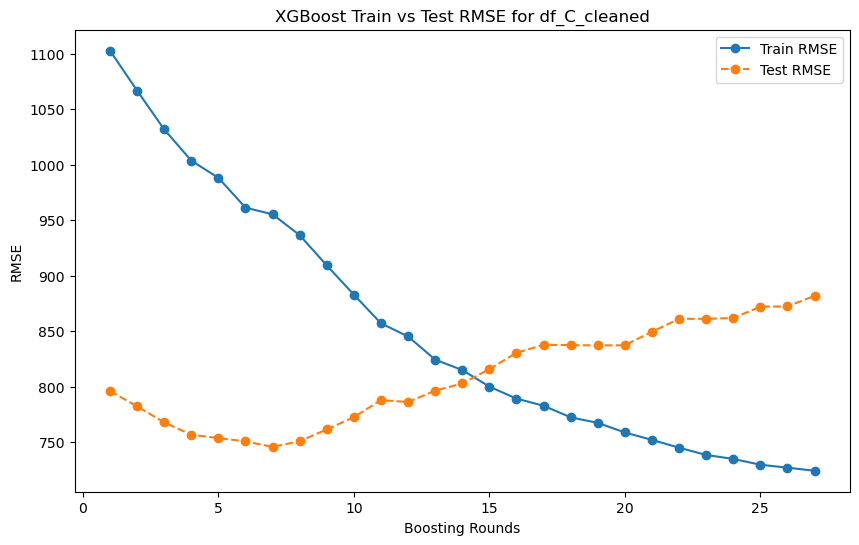

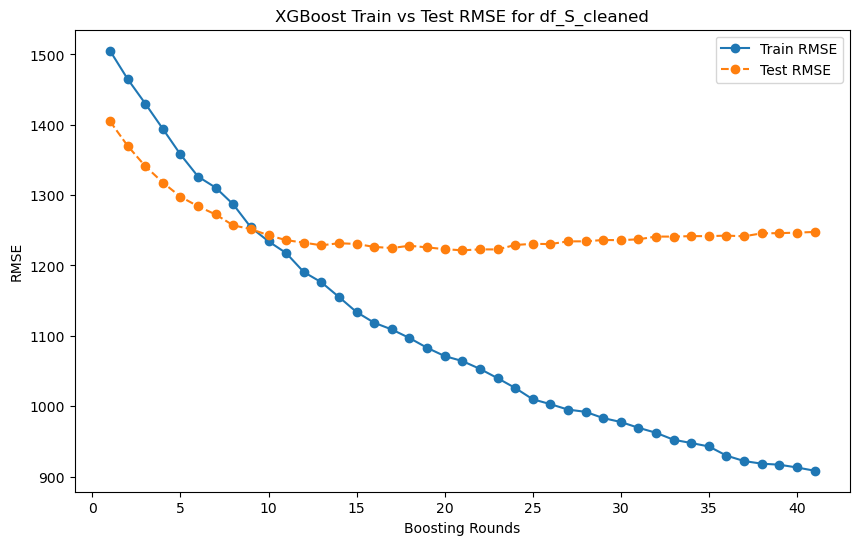

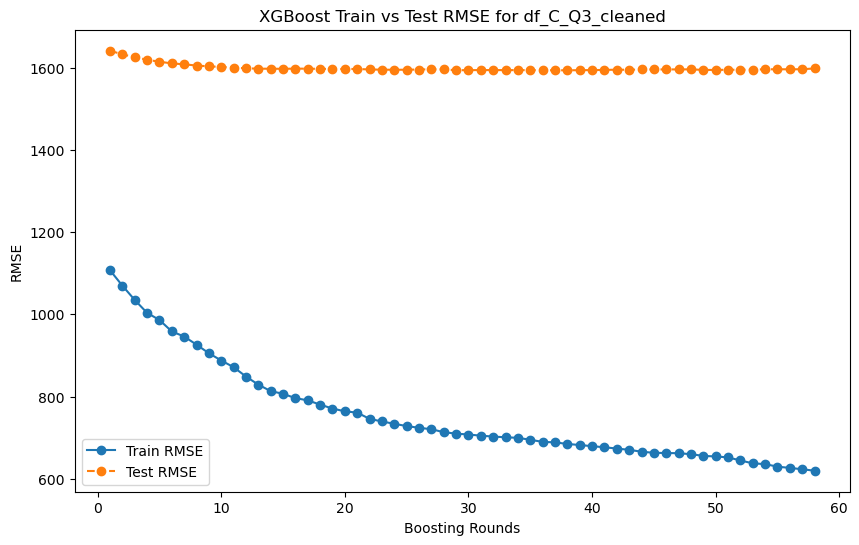

In [30]:
import matplotlib.pyplot as plt

# Dictionary to store train and test RMSE values for XGBoost
xgb_rmse_results = {}

# Loop through datasets and store RMSE values
for dataset_name, df in datasets.items():
    if df is None:
        continue  # Skip if dataset is not found

    print(f"\n🚀 Training XGBoost on {dataset_name}...")

    # Ensure column names are valid
    df.columns = df.columns.str.replace(" ", "_")

    # Extract predictors
    predictors_1, predictors_2, predictors_E = get_predictors(df)
    predictors = predictors_2  # Choose the predictor set

    # ----------------------------
    # Create Feature Matrices using `dmatrices()`
    # ----------------------------
    y, X = dmatrices("price ~ " + " + ".join(predictors), df, return_type="dataframe")

    # Convert y to 1D array to avoid `.ravel()` error
    y = y.values.ravel()
    
    # Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Ensure column names are valid for XGBoost
    X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
    X_test.columns = X_test.columns.str.replace(r"[\[\]<]", "", regex=True)

    # ----------------------------
    # Train XGBoost Model
    # ----------------------------
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    xgb_params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "learning_rate": 0.1,
        "max_depth": 6,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "alpha": 1.0,
        "lambda": 1.0,
    }

    evals_result = {}  # Store training process results

    xgb_model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=200,
        evals=[(dtrain, "Train"), (dtest, "Test")],
        early_stopping_rounds=20,
        evals_result=evals_result,
        verbose_eval=10
    )

    # Extract train and test RMSE per iteration
    train_rmse = evals_result["Train"]["rmse"]
    test_rmse = evals_result["Test"]["rmse"]

    # Store results
    xgb_rmse_results[dataset_name] = {"Train": train_rmse, "Test": test_rmse}

# ----------------------------
# Plot XGBoost Train vs Test RMSE for Each Dataset
# ----------------------------
for dataset_name, rmse_values in xgb_rmse_results.items():
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(range(1, len(rmse_values["Train"]) + 1), rmse_values["Train"], linestyle='-', marker='o', label=f"Train RMSE")
    ax.plot(range(1, len(rmse_values["Test"]) + 1), rmse_values["Test"], linestyle='--', marker='o', label=f"Test RMSE")

    ax.set_title(f"XGBoost Train vs Test RMSE for {dataset_name}")
    ax.set_xlabel("Boosting Rounds")
    ax.set_ylabel("RMSE")
    ax.legend(loc="best")
    plt.show()

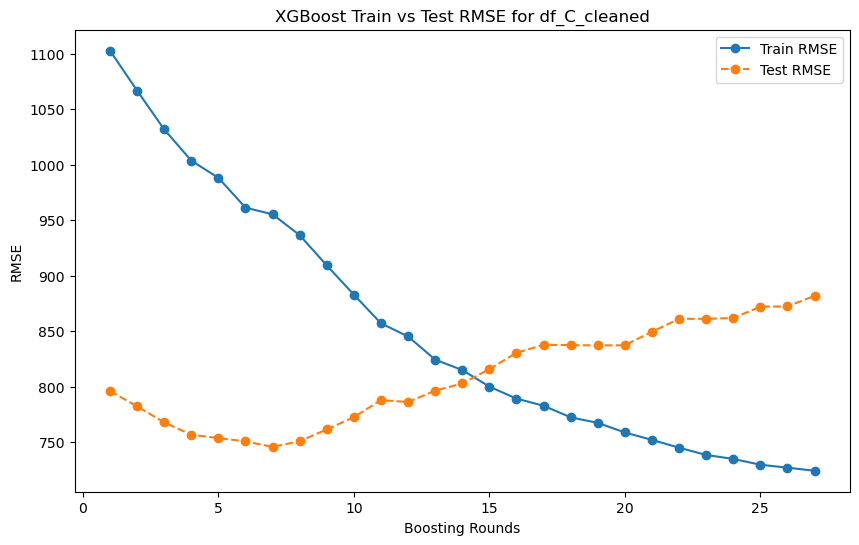

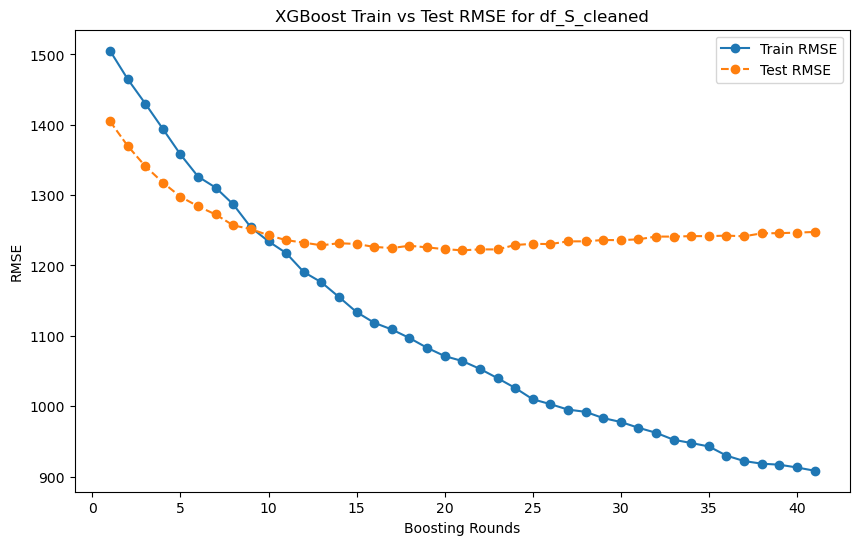

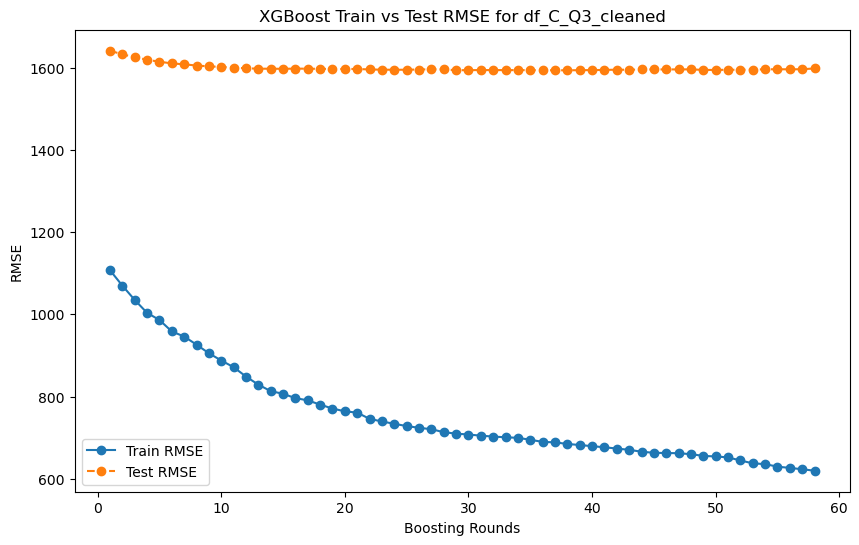

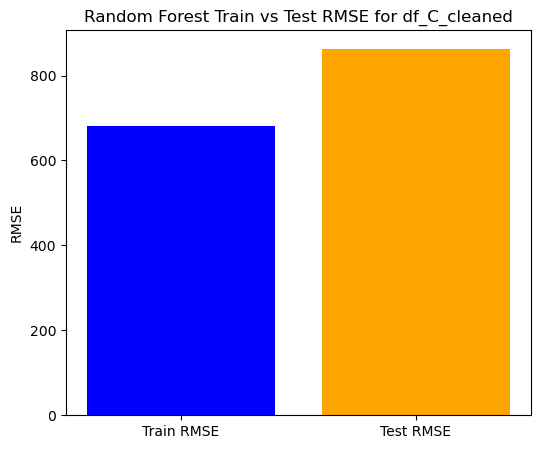

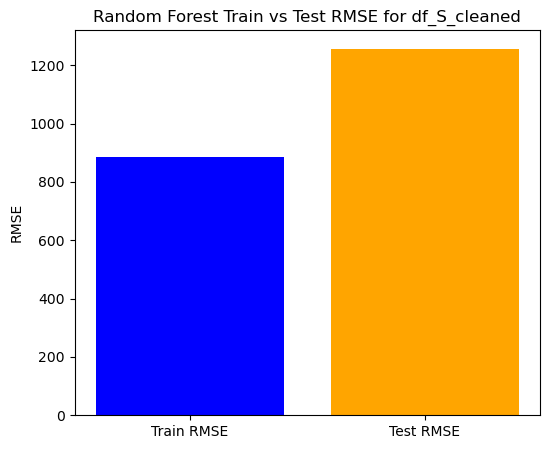

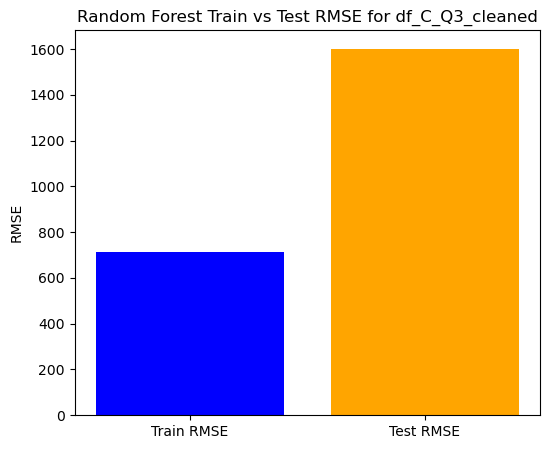

In [34]:
import matplotlib.pyplot as plt

# ----------------------------
# Plot XGBoost Train vs Test RMSE for Each Dataset
# ----------------------------
for dataset_name, rmse_values in xgb_rmse_results.items():
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(range(1, len(rmse_values["Train"]) + 1), rmse_values["Train"], linestyle='-', marker='o', label="Train RMSE")
    ax.plot(range(1, len(rmse_values["Test"]) + 1), rmse_values["Test"], linestyle='--', marker='o', label="Test RMSE")

    ax.set_title(f"XGBoost Train vs Test RMSE for {dataset_name}")
    ax.set_xlabel("Boosting Rounds")
    ax.set_ylabel("RMSE")
    ax.legend(loc="best")
    plt.show()

# ----------------------------
# Plot Random Forest Train vs Test RMSE for Each Dataset (Bar Chart)
# ----------------------------
for dataset_name, rmse_values in rf_rmse_results.items():
    fig, ax = plt.subplots(figsize=(6, 5))

    # Bar chart for train and test RMSE
    ax.bar(["Train RMSE", "Test RMSE"], [rmse_values["Train"], rmse_values["Test"]], color=["blue", "orange"])

    ax.set_title(f"Random Forest Train vs Test RMSE for {dataset_name}")
    ax.set_ylabel("RMSE")
    plt.show()


### XGBOOST Forest Train vs Test RMSE Analysis
- The first plot (`df_C_cleaned`) shows clear overfitting, as the test RMSE decreases initially but then increases with more boosting rounds.  
- The second plot (`df_S_cleaned`) has a more stable test RMSE but still shows signs of slight overfitting.  
- The third plot (`df_C_Q3_cleaned`) suggests underfitting, as the test RMSE remains mostly flat despite training improvements.  

### Random Forest Train vs Test RMSE Analysis
- The first plot (`df_C_cleaned`) shows a gap between train and test RMSE, indicating some overfitting but less severe than XGBoost.  
- The second plot (`df_S_cleaned`) also has a noticeable difference between train and test RMSE, suggesting overfitting.  
- The third plot (`df_C_Q3_cleaned`) exhibits a large gap between train and test RMSE, indicating significant overfitting.  


- Overall, Random Forest shows higher test RMSE values compared to XGBoost, suggesting that XGBoost provides better generalization while Random Forest tends to overfit more.  


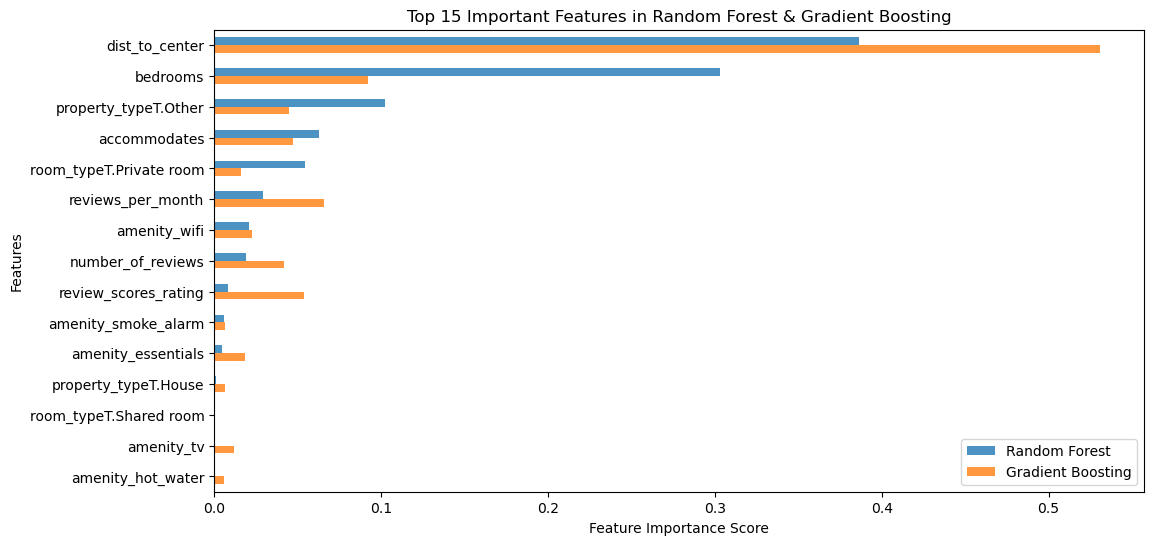

In [36]:

# Extract feature importance from Random Forest and Gradient Boosting models
rf_feature_importance = rf_model_cv.best_estimator_.feature_importances_
gbm_feature_importance = gbm_model_cv.best_estimator_.feature_importances_

# Get feature names
feature_names = X_train.columns

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Random Forest": rf_feature_importance,
    "Gradient Boosting": gbm_feature_importance
})

# Sort features by importance for better visualization
feature_importance_df = feature_importance_df.set_index("Feature")
feature_importance_df = feature_importance_df.sort_values(by="Random Forest", ascending=False).head(15)

# Plot feature importance
fig, ax = plt.subplots(figsize=(12, 6))
feature_importance_df.plot(kind="barh", ax=ax, alpha=0.8)
ax.set_title("Top 15 Important Features in Random Forest & Gradient Boosting")
ax.set_xlabel("Feature Importance Score")
ax.set_ylabel("Features")
ax.legend(loc="best")
plt.gca().invert_yaxis()  # Invert y-axis for better readability

# Display the plot
plt.show()

### Feature Importance in Random Forest & Gradient Boosting

- `dist_to_center` is the most important feature in both models, with Gradient Boosting assigning it the highest importance.  
- `bedrooms` is the second most important feature, with Random Forest giving it more weight than Gradient Boosting.  
- `property_type|Other` and `accommodates` have moderate importance in both models, but Gradient Boosting considers them slightly more relevant.  
- Features like `room_type|Private room`, `reviews_per_month`, and `number_of_reviews` have lower importance but still contribute to predictions.  
- Certain amenities (`smoke_alarm`, `essentials`, `wifi`, etc.) have minimal importance in both models.  
- Gradient Boosting tends to focus more on `dist_to_center`, whereas Random Forest distributes importance more evenly among other features.  


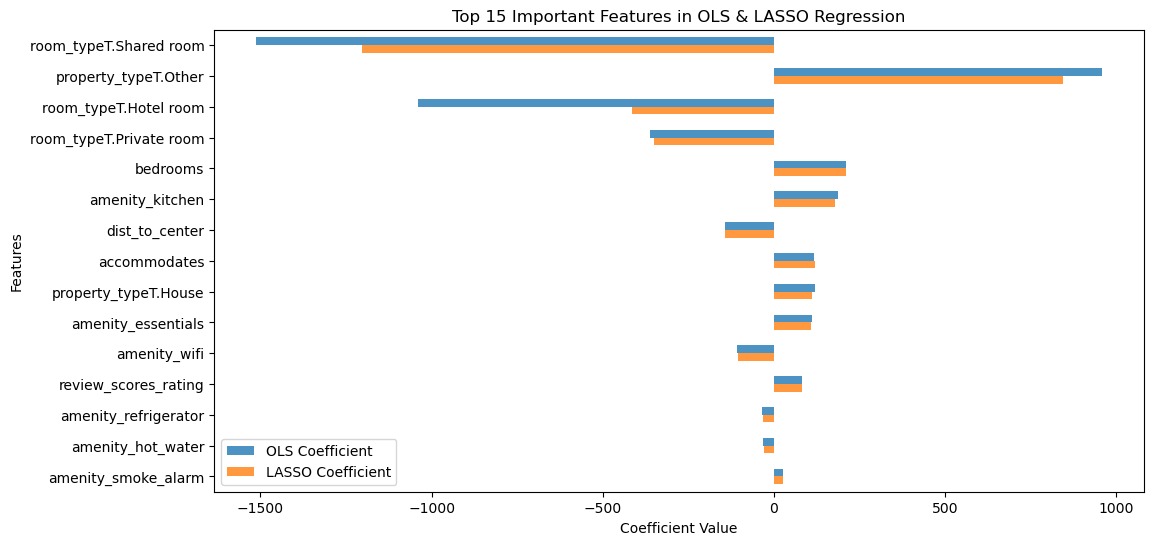

In [12]:

# Extract OLS and LASSO coefficients
ols_coefficients = lin_reg.coef_
lasso_coefficients = lasso_cv.best_estimator_.coef_

# Create a DataFrame for coefficient comparison
ols_lasso_df = pd.DataFrame({
    "Feature": feature_names,
    "OLS Coefficient": ols_coefficients,
    "LASSO Coefficient": lasso_coefficients
})

# Sort by absolute LASSO coefficient values
ols_lasso_df["Abs_LASSO"] = np.abs(ols_lasso_df["LASSO Coefficient"])
ols_lasso_df = ols_lasso_df.sort_values(by="Abs_LASSO", ascending=False).drop(columns=["Abs_LASSO"]).head(15)

# Plot OLS vs LASSO coefficients
fig, ax = plt.subplots(figsize=(12, 6))
ols_lasso_df.set_index("Feature").plot(kind="barh", ax=ax, alpha=0.8)
ax.set_title("Top 15 Important Features in OLS & LASSO Regression")
ax.set_xlabel("Coefficient Value")
ax.set_ylabel("Features")
ax.legend(loc="best")
plt.gca().invert_yaxis()  # Invert y-axis for better readability

# Display the plot
plt.show()

### OLS & LASSO Regression Results

### *** Understanding Coefficients**
- **Positive values** → Increase predicted price.  
- **Negative values** → Decrease predicted price.  

### **2. Key Observations**
- **Room Type**: Shared rooms lower price, while hotel rooms and houses increase it.  
- **Property Type**: Unconventional properties decrease price; houses raise it.  
- **Location**: Farther from the city center → Lower price.  
- **Amenities**: Kitchen, WiFi, and essentials increase price.  
- **Review Scores & Size**: Higher ratings and larger accommodations increase price.  

### **3. OLS vs. LASSO**
- **OLS**: Assigns values to all features, can overfit.  
- **LASSO**: Shrinks weak features to zero, improving interpretability.  

### **4. Key Takeaways**
- Shared rooms decrease price, while hotel rooms and houses increase it.  
- Central locations and essential amenities drive higher prices.  
- **LASSO is better** for feature selection, reducing unnecessary variables.  
